# <span style="color:red"> NSL Esercitazione 4 </span>
### <span style="color:pink">  Giacomo Boringhieri 13457A</span>

### <span style="color:blue">  Esercizio 7.1</span>

Nella quarta esercitazione è stata introdotta un'approssimazione che trascura una parte dell'integrale nel calcolo dell'energia potenziale: in particolare, si è ignorato il contributo della coda, cioè l'intervallo $[R_{cut}, \infty)$. Per un potenziale generico, la correzione dovuta alla coda può essere espressa come:

$$
\langle V \rangle_{tail} = 2 \pi \rho N \int_{r_{cut}}^{\infty} dr \, r^2 v(r) g(r) \approx 2 \pi \rho N \int_{r_{cut}}^{\infty} dr \, r^2 v(r)
$$

Se il raggio di taglio $R_{cut}$ è sufficientemente grande, le oscillazioni della funzione di distribuzione radiale $g(r)$ diventano trascurabili, permettendo di approssimare $g(r) \approx 1$.  

Nel caso specifico del potenziale di Lennard-Jones, la correzione per particella diventa:

$$
\frac{\langle V_{LJ} \rangle_{tail}}{N} \approx \frac{8 \pi \rho \epsilon}{9 r_{cut}^9} - \frac{8 \pi \rho \epsilon}{3 r_{cut}^3}
$$

La stessa approssimazione può essere applicata anche alla pressione, con la correzione di coda espressa da:

$$
\frac{\langle w_{LJ} \rangle_{tail}}{3 N \epsilon} \approx 32 \pi \rho \left[ \frac{1}{9 r_{cut}^9} - \frac{1}{6 r_{cut}^3} \right]
$$

Ho implementato nel codice queste correzzioni di coda

### <span style="color:blue">  Esercizio 7.2</span>

In questo esercizio ho utilizzato il codice NSL_SIMULATOR per studiare le fluttuazioni dell’energia potenziale per particella, $U/N$, durante simulazioni di Monte Carlo (MC) nell’insieme canonico (NVT) e di Molecular Dynamics (MD) nel microcanonico (NVE), entrambe nella fase liquida ($\rho^* = 0.8$, $T^* = 1.1$) con raggio di taglio $r_c^* = 2.5$.  

Per le simulazioni MC è stato scelto un passo temporale $dt = 0.1$, in modo da mantenere un’accettanza attorno al 50%, mentre per MD è stato utilizzato $dt^* = 0.001$.  

L’obiettivo principale dell’esercizio è determinare la lunghezza ottimale dei blocchi da utilizzare nella stima delle incertezze, essenziale per ottenere errori statistici affidabili delle grandezze termodinamiche.  

Per entrambe le metodologie, è stata eseguita una fase preliminare di equilibriazione. Una volta raggiunto l’equilibrio, sono stati raccolti dati per **$M = 5 \times 10^5$** passi, registrando ad ogni passo l’energia potenziale per particella $U/N$ e la relativa incertezza.  

Sfruttando i valori istantanei di $U/N$, cioè quelli registrati ad ogni passo, è stata calcolata la funzione di autocorrelazione. Le funzioni di autocorrelazione misurano quanto i valori della serie temporale siano correlati tra loro a diversi intervalli di passi (lag). In pratica, indicano per quanti passi i dati restano “dipendenti” tra loro, fornendo così il tempo di correlazione caratteristico del sistema. Questo è fondamentale per capire dopo quanti passi i dati diventano statisticamente indipendenti, informazione utile per determinare la dimensione minima dei blocchi nella tecnica del data blocking.  

Successivamente, ho applicato il metodo del data blocking per stimare l’incertezza statistica di $\langle U/N \rangle$ in funzione della dimensione del blocco $L$, variando $L$ da $10$ fino a $5000$ e calcolando per ciascun caso la deviazione standard tra i blocchi.  

L’intera procedura è stata ripetuta sia per la simulazione MC che per quella MD, permettendo un confronto sull’efficienza statistica dei due approcci.

τ MD ≈ 59.7 passi
τ MC ≈ 34.2 passi


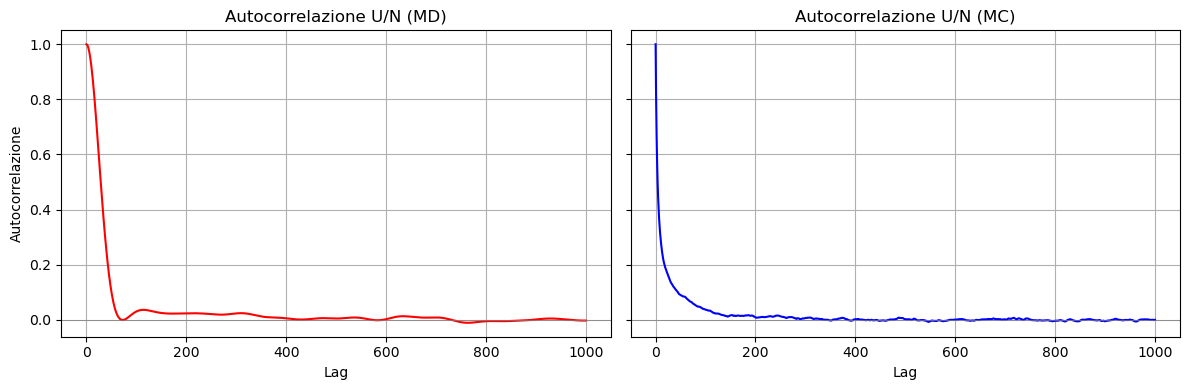

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

data_md = np.loadtxt("NSL_SIMULATOR/OUTPUT/equilibratedMD/potential_energy.dat")
data_mc = np.loadtxt("NSL_SIMULATOR/OUTPUT/equilibratedMC/potential_energy.dat")
energy_md = data_md[:, 1]
energy_mc = data_mc[:, 1]

# Numero massimo di lag
max_lag = 1000

# Calcolo l'autocorrelazione
acf_md = acf(energy_md, nlags=max_lag, fft=True)
acf_mc = acf(energy_mc, nlags=max_lag, fft=True)

# tempo di autocorrelazione
def autocorr_time(acf_values):
    for i, val in enumerate(acf_values):
        if val < 0:
            return 1 + 2 * np.sum(acf_values[1:i])
    return 1 + 2 * np.sum(acf_values[1:])

tau_md = autocorr_time(acf_md)
tau_mc = autocorr_time(acf_mc)

print(f"τ MD ≈ {tau_md:.1f} passi")
print(f"τ MC ≈ {tau_mc:.1f} passi")

# Grafici separati
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

ax1.plot(acf_md, color='red')
ax1.axhline(0, color='gray', lw=0.5)
ax1.set_xlabel("Lag")
ax1.set_ylabel("Autocorrelazione")
ax1.set_title("Autocorrelazione U/N (MD)")
ax1.grid(True)

ax2.plot(acf_mc, color='blue')
ax2.axhline(0, color='gray', lw=0.5)
ax2.set_xlabel("Lag")
ax2.set_title("Autocorrelazione U/N (MC)")
ax2.grid(True)

plt.tight_layout()
plt.show()

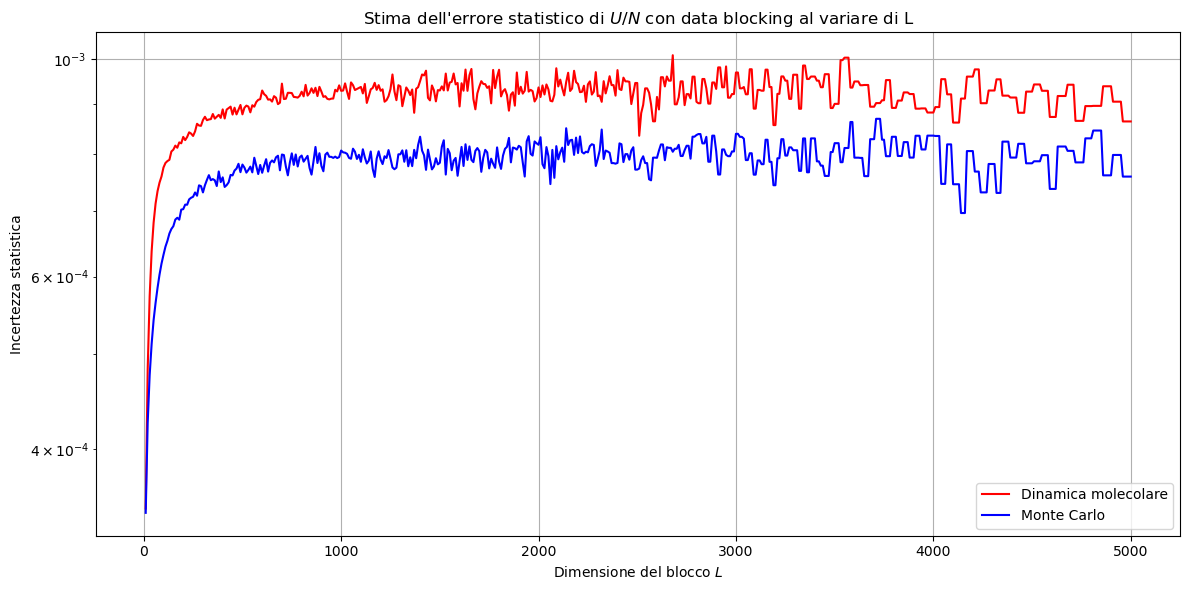

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def block_average(data, n_blocks):
    N = len(data)
    if N % n_blocks != 0:
        data = data[:N - (N % n_blocks)]  # Trim so divisible by n_blocks
    block_size = len(data) // n_blocks
    blocks = data.reshape((n_blocks, block_size))
    means = blocks.mean(axis=1)
    mean_of_means = means.mean()
    std_error = np.sqrt(np.var(means, ddof=1) / n_blocks)
    return mean_of_means, std_error

T, enMD, _, errMD = np.loadtxt("NSL_SIMULATOR/OUTPUT/equilibratedMD/potential_energy.dat", usecols=(0, 1, 2, 3), unpack=True)
enMC, errMC = np.loadtxt("NSL_SIMULATOR/OUTPUT/equilibratedMC/potential_energy.dat", usecols=(1, 3), unpack=True)

# Definisco la dimensione dei blocchi L
min_L = 10
max_L = 5000
step_L = 10
block_sizes = np.arange(min_L, max_L + 1, step_L)

errors_md = []
errors_mc = []
valid_block_sizes_md = []
valid_block_sizes_mc = []

M_md = len(enMD)
M_mc = len(enMC)

# MD
for L in block_sizes:
    if M_md // L < 2:
        continue  # Ho bisogno di almeno due blocchi per calcolare la varianza
    n_blocks = M_md // L
    _, err = block_average(enMD, n_blocks)
    errors_md.append(err)
    valid_block_sizes_md.append(L)

# MC
for L in block_sizes:
    if M_mc // L < 2:
        continue
    n_blocks = M_mc // L
    _, err = block_average(enMC, n_blocks)
    errors_mc.append(err)
    valid_block_sizes_mc.append(L)

# Plotting
plt.figure(figsize=(12, 6))
plt.semilogy(valid_block_sizes_md, errors_md, label='Dinamica molecolare', color='red', markersize=3)
plt.semilogy(valid_block_sizes_mc, errors_mc, label='Monte Carlo', color='blue', markersize=3)
plt.xlabel("Dimensione del blocco $L$")
plt.ylabel("Incertezza statistica")
plt.title("Stima dell'errore statistico di $U/N$ con data blocking al variare di L")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Il primo grafico mostra la funzione di autocorrelazione normalizzata dell’energia potenziale per particella, $U/N$, calcolata sia dalle simulazioni Monte Carlo (MC) sia da quelle di Molecular Dynamics (MD). Entrambe le curve evidenziano un decadimento significativo entro circa 200-300 passi, suggerendo che oltre questo intervallo le configurazioni diventano sostanzialmente indipendenti dal punto di vista statistico.  

Confrontando i due metodi:  
- Nel caso MC, la correlazione diminuisce più rapidamente nelle prime decine di passi.  
- La curva MD presenta una correlazione più persistente all’inizio, ma tende a ridursi fino a valori simili a quelli del MC per lag più grandi.  

Il secondo grafico rappresenta l’incertezza statistica di $\langle U/N \rangle$ in funzione della dimensione del blocco $L$.  
- Per blocchi piccoli, inferiori al tempo di correlazione, l’errore è sottostimato poiché i dati all’interno di ciascun blocco non sono indipendenti.  
- All’aumentare di $L$, la stima dell’errore cresce fino a stabilizzarsi su un plateau, che corrisponde al caso in cui i blocchi sono sufficientemente grandi da essere considerati statisticamente indipendenti.  

Questa regione piatta rappresenta quindi l’incertezza corretta, che riflette le reali fluttuazioni del sistema.  

Per entrambe le simulazioni, una dimensione del blocco con $L > 2000$ risulta adeguata per garantire l’indipendenza statistica tra i blocchi.

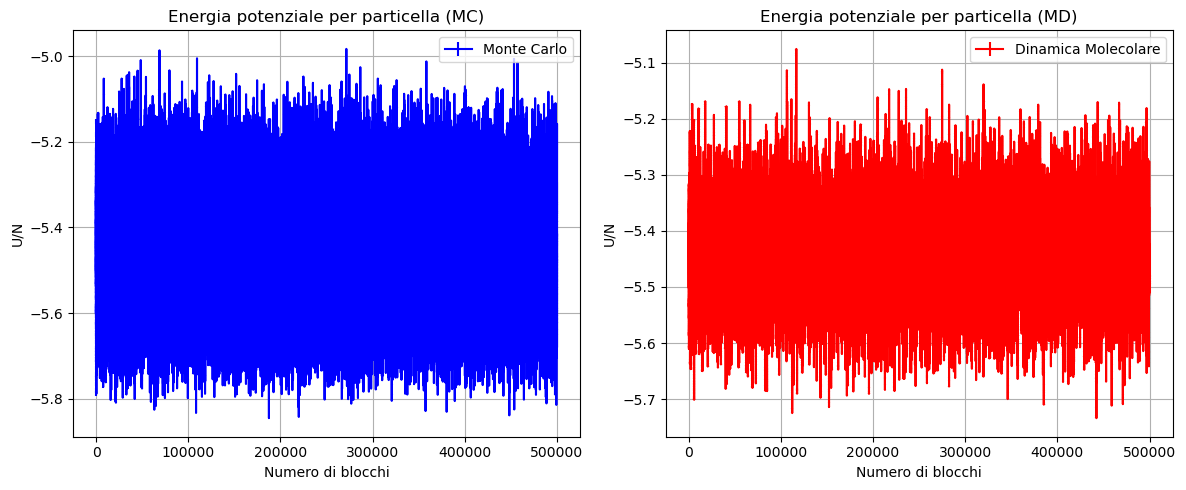

In [2]:
import matplotlib.pyplot as plt
import numpy as np

N = 108  # Numero totale di particelle

# Carico i dati dal file
data_U_MC = np.loadtxt("NSL_SIMULATOR/OUTPUT/equilibratedMC/potential_energy.dat")
data_U_MD = np.loadtxt("NSL_SIMULATOR/OUTPUT/equilibratedMD/potential_energy.dat")

# Estraggo le colonne di dati
x = data_U_MC[:, 0]         # Prima colonna: numero di blocchi
y_U_MC = data_U_MC[:, 1]    # Seconda colonna: valori istantanei
err_U_MC = data_U_MC[:, 3]  # Quarta colonna: errore

y_U_MD = data_U_MD[:, 1]
err_U_MD = data_U_MD[:, 3]

# Creazione di una figura con 1 riga e 2 colonne
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# U/N Monte Carlo (primo grafico)
axes[0].errorbar(x, y_U_MC, yerr=err_U_MC, color='b', label='Monte Carlo')
axes[0].set_xlabel("Numero di blocchi")
axes[0].set_ylabel("U/N")
axes[0].set_title("Energia potenziale per particella (MC)")
axes[0].legend()
axes[0].grid(True)

# U/N Dinamica Molecolare (secondo grafico)
axes[1].errorbar(x, y_U_MD, yerr=err_U_MD, color='r', label='Dinamica Molecolare')
axes[1].set_xlabel("Numero di blocchi")
axes[1].set_ylabel("U/N")
axes[1].set_title("Energia potenziale per particella (MD)")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

### <span style="color:blue">  Esercizio 7.3</span>

Ho implementato nel codice  la funzione di distribuzione radiale, $g(r)$. Essa rappresenta la probabilità normalizzata di trovare due particelle separate da una distanza $r$. La definizione matematica è:  

$$
g(r) = \frac{1}{\rho N \Delta V(r)} \left\langle \sum_{i \neq j=1}^{N} \delta(|\vec{r}_i - \vec{r}_j| - r) \right\rangle
$$

dove $\Delta V(r) = \frac{4\pi}{3} \left[(r + dr)^3 - r^3\right]$ è il volume della corona sferica tra $r$ e $r + dr$.  

Durante la simulazione, per ogni coppia di particelle $(i,j)$ si calcola la distanza $|\vec{r}_i - \vec{r}_j|$. Se questa distanza rientra nell’intervallo $[r, r+dr)$, il bin corrispondente dell’istogramma viene incrementato di 2 (per considerare la simmetria delle coppie). Al termine della simulazione, l’istogramma viene normalizzato dividendo per $\rho N \Delta V(r)$, ottenendo così la funzione di distribuzione radiale $g(r)$.

### <span style="color:blue">  Esercizio 7.4</span>

In questo esercizio ho utilizzato il codice aggiornato per confrontare i risultati ottenuti simulando lo stesso sistema con due metodologie differenti: Monte Carlo nell’insieme canonico (NVT) e Molecular Dynamics nell’insieme microcanonico (NVE).  

Per entrambi i metodi, il sistema è stato prima equilibrato utilizzando **20000 blocchi da un singolo passo ciascuno**, dopodiché è stata eseguita una produzione di **30 blocchi da 3000 passi ciascuno**.  

I grafici riportati mostrano i valori calcolati per la pressione e l’energia potenziale per particella, includendo le rispettive incertezze, confrontando così la distribuzione $g(r)$ ottenuta dai due metodi.

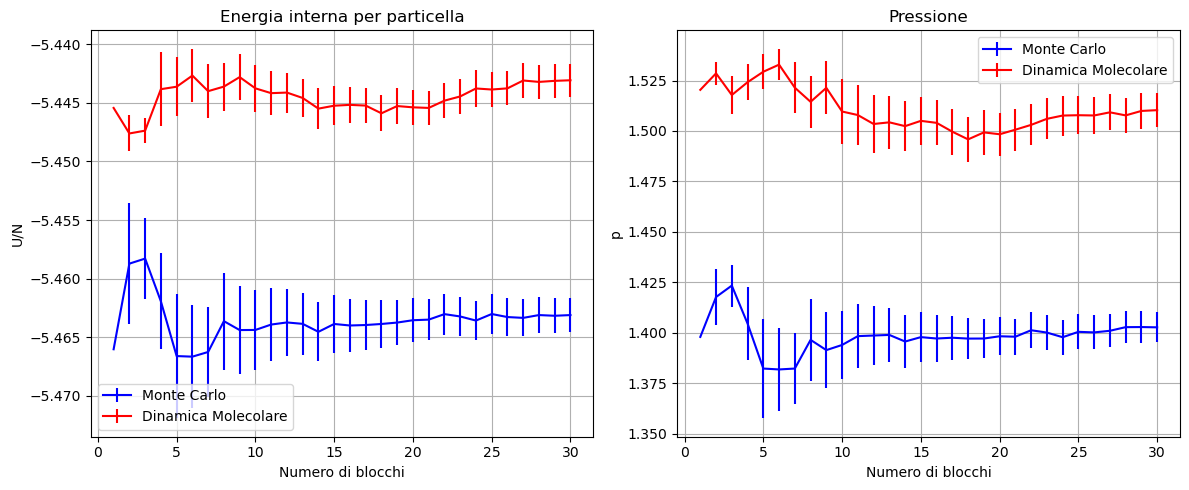

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

N = 108 # numero di particelle

# Carico i dati dal file
data_U_MC = np.loadtxt("NSL_SIMULATOR_/OUTPUT/equilibratedMC/potential_energy.dat") # energia potenziale
data_U_MD = np.loadtxt("NSL_SIMULATOR_/OUTPUT/equilibratedMD/potential_energy.dat")
data_p_MC = np.loadtxt("NSL_SIMULATOR_/OUTPUT/equilibratedMC/pressure.dat") 
data_p_MD = np.loadtxt("NSL_SIMULATOR_/OUTPUT/equilibratedMD/pressure.dat")

N_blocchi = data_U_MC[:, 0]   # Prima colonna: contiene il numero di blocchi

U_MC = data_U_MC[:,2] # Terza colonna: contiene il valore medio di energia potenziale
U_MD = data_U_MD[:,2] # Terza colonna: contiene il valore medio di energia potenziale
error_U_MC = data_U_MC[:,3] # Quarta colonna: contiene l'errore
error_U_MD = data_U_MD[:,3] # Quarta colonna: contiene l'errore

p_MC = data_p_MC[:,2] # Terza colonna: contiene il valore medio di pressione
p_MD = data_p_MD[:,2] # Terza colonna: contiene il valore medio di pressione
error_p_MC = data_p_MC[:,3] # Quarta colonna: contiene l'errore
error_p_MD = data_p_MD[:,3] # Quarta colonna: contiene l'errore



fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 riga, 2 colonne

# Primo grafico
axes[0].errorbar(N_blocchi, U_MC, yerr=error_U_MC , color='b', label='Monte Carlo')
axes[0].errorbar(N_blocchi, U_MD, yerr=error_U_MD , color='r', label='Dinamica Molecolare')
axes[0].set_title("Energia interna per particella")
axes[0].set_xlabel("Numero di blocchi")
axes[0].set_ylabel("U/N")
axes[0].legend()
axes[0].grid(True)

axes[1].errorbar(N_blocchi, p_MC, yerr=error_p_MC, color='b', label='Monte Carlo')
axes[1].errorbar(N_blocchi, p_MD, yerr=error_p_MD, color='r', label='Dinamica Molecolare')
axes[1].set_title("Pressione")
axes[1].set_xlabel("Numero di blocchi")
axes[1].set_ylabel("p")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

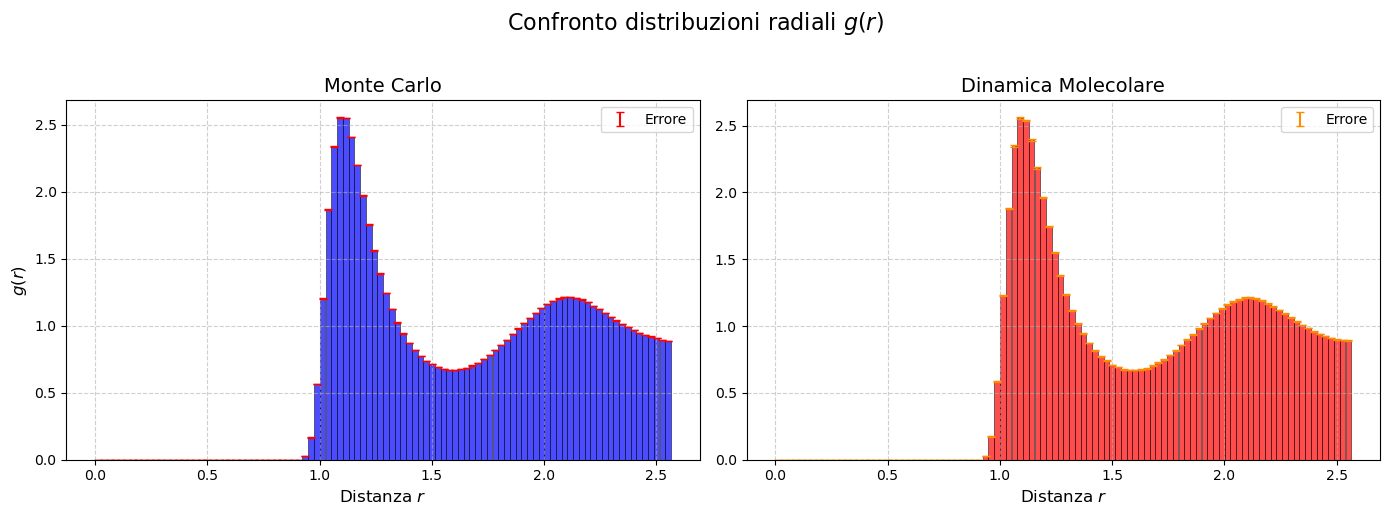

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Parametri
n_bins = 100       # Numero di bin per blocco
target_block = 30  # Blocco da visualizzare (1-based)

# Funzione per caricare e estrarre i dati del blocco specificato
def load_block_data(filepath, block, n_bins):
    data = np.loadtxt(filepath)
    start_idx = (block - 1) * n_bins
    end_idx = block * n_bins
    return data[start_idx:end_idx, 0], data[start_idx:end_idx, 1], data[start_idx:end_idx, 2]

# Caricamento dati
r_mc, g_mc, err_mc = load_block_data("NSL_SIMULATOR_/OUTPUT/equilibratedMC/gofr.dat", target_block, n_bins)
r_md, g_md, err_md = load_block_data("NSL_SIMULATOR_/OUTPUT/equilibratedMD/gofr.dat", target_block, n_bins)

# Creazione figura con due subplot affiancati
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Monte Carlo
ax1.bar(r_mc, g_mc, 
        color='blue', 
        alpha=0.7, 
        width=(r_mc[-1] - r_mc[0])/n_bins,
        edgecolor='black',
        linewidth=0.5)
ax1.errorbar(r_mc, g_mc, yerr=err_mc,
             fmt='none', 
             ecolor='red',
             capsize=3,
             label='Errore')
ax1.set_title(f'Monte Carlo', fontsize=14)
ax1.set_xlabel('Distanza $r$', fontsize=12)
ax1.set_ylabel('$g(r)$', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend()

# Plot Dinamica Molecolare
ax2.bar(r_md, g_md, 
        color='red', 
        alpha=0.7, 
        width=(r_md[-1] - r_md[0])/n_bins,
        edgecolor='black',
        linewidth=0.5)
ax2.errorbar(r_md, g_md, yerr=err_md,
             fmt='none', 
             ecolor='darkorange',
             capsize=3,
             label='Errore')
ax2.set_title(f'Dinamica Molecolare', fontsize=14)
ax2.set_xlabel('Distanza $r$', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend()

# Titolo generale e layout
plt.suptitle(f'Confronto distribuzioni radiali $g(r)$', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Dai grafici precedenti si nota come i due metodi producano valori medi molto simili sia per la pressione sia per l’energia potenziale per particella. Tuttavia, i risultati non coincidono perfettamente all’interno delle incertezze statistiche. Questa lieve discrepanza può essere spiegata dal fatto che Monte Carlo e Molecular Dynamics campionano lo stesso ensemble termodinamico solo nel limite termodinamico, cioè quando il numero di particelle tende all’infinito.  

Nel nostro caso, poiché le simulazioni sono state effettuate con un numero finito e relativamente ridotto di particelle (108), è naturale osservare piccole differenze tra i due metodi. Tali discrepanze possono inoltre derivare dalla sensibilità della pressione alla temperatura media del sistema.

Per quanto riguarda le funzioni di distribuzione radiale, $g(r)$, riportate negli ultimi grafici, si osserva una quasi perfetta sovrapposizione tra i risultati dei due metodi, in piena concordanza con le previsioni teoriche. Questo conferma che, nonostante le piccole differenze riscontrate nei valori medi di pressione ed energia potenziale, sia Monte Carlo sia Molecular Dynamics riescono a descrivere correttamente la struttura microscopica del sistema. Le discrepanze rilevate possono quindi essere attribuite principalmente a fluttuazioni statistiche o a effetti dovuti al numero finito di particelle, piuttosto che a errori intrinseci nelle simulazioni.